In [ ]:
import sys
sys.path.append('../')

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import healpy as hp
from illustris_frb import frb_simulation
import time

figpath = '/home/tnguser/frb_project/figures'

In [29]:
origin = 500 * np.array([50, 70, 23])
sim = frb_simulation('L205n2500TNG', origin=origin)

z = 0.4
x = sim.comoving_distance(z)

In [37]:
# compute angular size of a bin at z = 0.4, in arcmin
print(f'Angular size of {sim.binsize} ckpc/h bin at z={z}: {np.degrees(sim.binsize / x)*60:.2f}\'')

Angular size of 500 ckpc/h bin at z=0.4: 1.59'


In [38]:
# estimate angular distance between consecutive bad rays (lower bound), in degrees
print(f'Lower bound on angular distance between consecutive bad rays: {np.degrees(np.arcsin(sim.boxsize / x)):.2f} deg')

Lower bound on angular distance between consecutive bad rays: 10.91 deg


## getting all bad sky regions via brute force

In [61]:
nside = 64
print(f"Approximate resolution at nside {nside} is {hp.nside2resol(nside, arcmin=True)/60:.1f} deg")

npix = hp.nside2npix(nside)
pixels = np.arange(npix)
print(f"Number of pixels: {npix}")

Approximate resolution at nside 64 is 0.9 deg
Number of pixels: 49152


In [62]:
start=time.time()
thetas, phis = hp.pix2ang(nside=nside, ipix=pixels)
max_dists = sim.get_max_dist(thetas, phis)

print(f'Compute time: {time.time()-start:.2f} s')

Compute time: 40.95 s


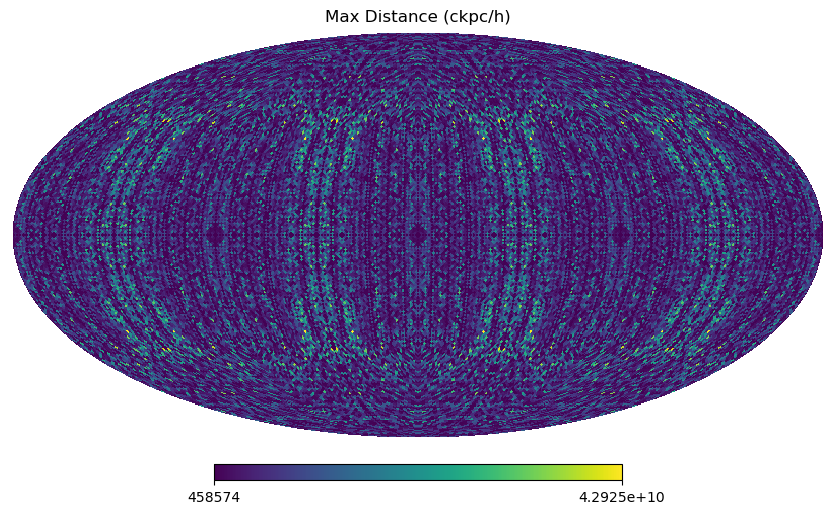

In [63]:
hp.mollview(max_dists, title="Max Distance (ckpc/h)")

In [ ]:
#why tf do these holes on theta=pi/2 exist they should not

In [64]:
#cap at z = 2
x2 = sim.comoving_distance(2)

max_dists_ = np.array(max_dists)
max_dists_[ max_dists > x2 ] = x2

max_zs = sim.z_from_dist(max_dists_)

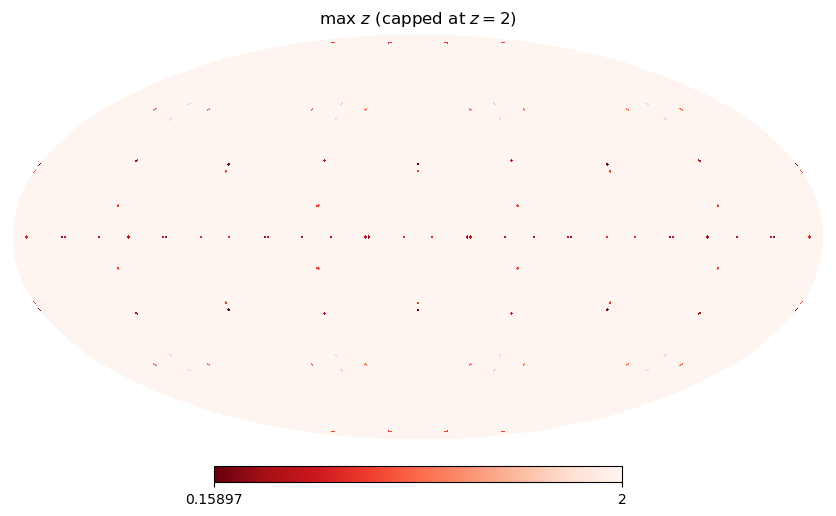

In [67]:
cmap = plt.colormaps['Reds'].reversed()
hp.mollview(max_zs, title=r"max $z$ (capped at $z=2$)", cmap=cmap)

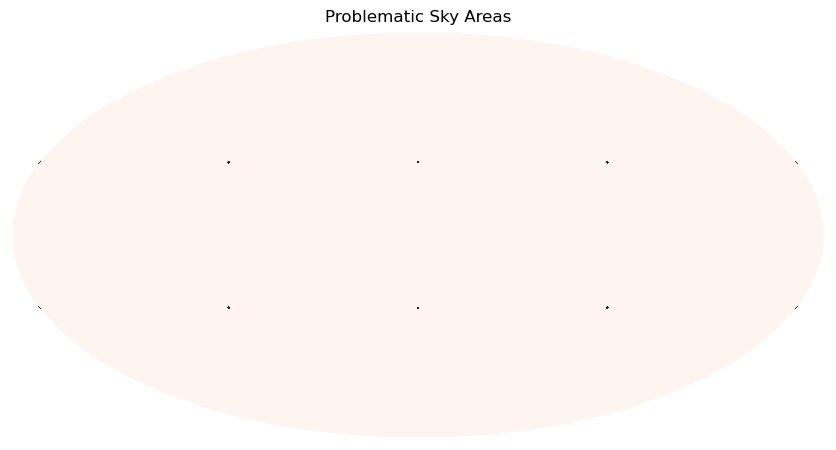

In [68]:
hp.mollview(max_zs > 0.4, title=r"Problematic Sky Areas", cmap=cmap, cbar=False)

In [70]:
np.nonzero(max_zs < 0.4) #indices of problematic pixels

(array([13440, 13504, 13568, 13632, 35456, 35520, 35584, 35648]),)

This is not very helpful because the angular resolution of the pixels is not good enough to pick out all the problematic points--and it would be too computationally prohibitive to do so.

## get all bad sky regions by thinking about it xd

We have to think about all integer vectors with $|\vec{v}| \leq \frac{x}{\mathrm{boxsize}}$. We can do this via:

In [126]:
def get_bad_vecs(x, boxsize):
    
    n = int(np.ceil(x/boxsize))
    vecs = np.indices((2*n+1, 2*n+1, 2*n+1)).reshape((3, (2*n+1)**3)).T - n # integer vecs in cube
    vecs = vecs[ np.any(vecs, axis=1) ] # get rid of (0,0,0)
    
    gcd = np.gcd(np.gcd(vecs[:,0], vecs[:,1]), vecs[:,2])
    vecs = np.unique(np.floor_divide(vecs.T, gcd).T, axis=0) # get rid of vectors that point in the same direction
    
    return vecs[ (norm(vecs, axis=1) <= x/boxsize) ] 

Applying to our simulation at $z=0.4$:

In [127]:
bad_vecs = get_bad_vecs(x, sim.boxsize)

# spherical coordinates
bad_thetas, bad_phis = hp.vec2ang(bad_vecs)

Resolution: 27.5'


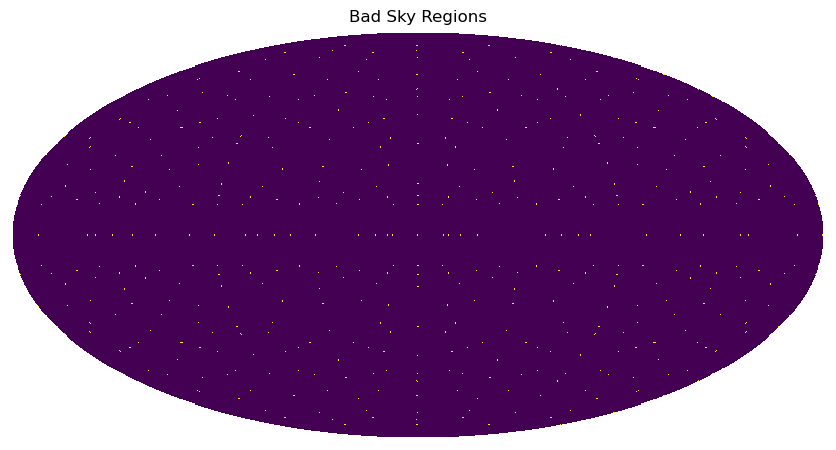

In [130]:
# visualize

nside = 128
print(f"Resolution: {hp.nside2resol(nside, arcmin=True):.1f}\'")

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
pix_arr = np.zeros(hp.nside2npix(nside))
pix_arr[ bad_pixels ] = 1 

hp.mollview(pix_arr, title="Bad Sky Regions", cbar=False)

Focusing our attention to the points near the equatorial plane:

In [139]:
mask = np.isclose(bad_thetas, np.pi/2)

In [147]:
bad_eq_phis = np.sort(bad_phis[mask])
np.degrees(bad_eq_phis)

array([  0.        ,  11.30993247,  14.03624347,  18.43494882,
        26.56505118,  33.69006753,  36.86989765,  45.        ,
        53.13010235,  56.30993247,  63.43494882,  71.56505118,
        75.96375653,  78.69006753,  90.        , 101.30993247,
       104.03624347, 108.43494882, 116.56505118, 123.69006753,
       126.86989765, 135.        , 143.13010235, 146.30993247,
       153.43494882, 161.56505118, 165.96375653, 168.69006753,
       180.        , 191.30993247, 194.03624347, 198.43494882,
       206.56505118, 213.69006753, 216.86989765, 225.        ,
       233.13010235, 236.30993247, 243.43494882, 251.56505118,
       255.96375653, 258.69006753, 270.        , 281.30993247,
       284.03624347, 288.43494882, 296.56505118, 303.69006753,
       306.86989765, 315.        , 323.13010235, 326.30993247,
       333.43494882, 341.56505118, 345.96375653, 348.69006753])

In [151]:
np.ediff1d(np.degrees(bad_eq_phis)) #width of safe equatorial regions, in degrees

array([11.30993247,  2.72631099,  4.39870535,  8.13010235,  7.12501635,
        3.17983012,  8.13010235,  8.13010235,  3.17983012,  7.12501635,
        8.13010235,  4.39870535,  2.72631099, 11.30993247, 11.30993247,
        2.72631099,  4.39870535,  8.13010235,  7.12501635,  3.17983012,
        8.13010235,  8.13010235,  3.17983012,  7.12501635,  8.13010235,
        4.39870535,  2.72631099, 11.30993247, 11.30993247,  2.72631099,
        4.39870535,  8.13010235,  7.12501635,  3.17983012,  8.13010235,
        8.13010235,  3.17983012,  7.12501635,  8.13010235,  4.39870535,
        2.72631099, 11.30993247, 11.30993247,  2.72631099,  4.39870535,
        8.13010235,  7.12501635,  3.17983012,  8.13010235,  8.13010235,
        3.17983012,  7.12501635,  8.13010235,  4.39870535,  2.72631099])

Now, let's get the equatorial unsafe points

In [145]:
safe_dtheta = np.amin(np.abs(bad_thetas[~mask] - np.pi/2))
print(f'The band of latitudes of +/-{safe_dtheta:.2f} rad or +/-{np.degrees(safe_dtheta):.2f} deg is safe, barring equatorial unsafe points')

The band of latitudes of +/-0.19 rad or +/-11.10 deg is safe, barring equatorial unsafe points


In [165]:
#get indices where we are close to the maximum
safe_eq_indices = np.nonzero(np.isclose(np.ediff1d(np.degrees(bad_eq_phis)), np.amax(np.ediff1d(np.degrees(bad_eq_phis)))))[0]

#print safe regions in degrees
print(f'-{np.degrees(safe_dtheta):.2f} < theta - 90 < {np.degrees(safe_dtheta):.2f}\n')
for i in safe_eq_indices:
    print(f'{np.degrees(bad_eq_phis)[i]:.2f} < phi < {np.degrees(bad_eq_phis)[i+1]:.2f}')

-11.10 < theta - 90 < 11.10

0.00 < phi < 11.31
78.69 < phi < 90.00
90.00 < phi < 101.31
168.69 < phi < 180.00
180.00 < phi < 191.31
258.69 < phi < 270.00
270.00 < phi < 281.31


In [168]:
#print safe regions in radians
print(f'dtheta = {safe_dtheta:.3f}')
print(f'{-safe_dtheta+(np.pi/2):.3f} < theta < {safe_dtheta+(np.pi/2):.3f}\n')
for i in safe_eq_indices:
    print(f'{bad_eq_phis[i]:.3f} < phi < {bad_eq_phis[i+1]:.3f}')

dtheta = 0.194
1.377 < theta < 1.764

0.000 < phi < 0.197
1.373 < phi < 1.571
1.571 < phi < 1.768
2.944 < phi < 3.142
3.142 < phi < 3.339
4.515 < phi < 4.712
4.712 < phi < 4.910


In [171]:
print(f'Error margin: {sim.binsize / x} rad')

Error margin: 0.0004615323070754232 rad


In [172]:
sim.boxsize / x

0.18922824590092352